# Final Project
Logan Cooper

In [112]:
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLSResults
from typing import Tuple

## Data

### Data Import

#### NCDB Building Age Data (2000)

In [2]:
ncdb_dtypes = {
    'tract_id': str,
    'workers_taking_transit': int,
    'prop_taking_transit': float,
    'built_1999_2000': int,
    'built_1995_1998': int,
    'built_1990_1994': int,
    'built_1980_1989': int,
    'built_1970_79': int,
    'built_1960_69': int,
    'built_1950_59': int,
    'built_1940_49': int,
    'built_1939_earlier': int
}
ncdb_data = pd.read_csv('./data/NCDB_2000.csv', dtype=ncdb_dtypes)
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180


In [3]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920
...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158


In [4]:
ncdb_data['pub_trans_gt_10pct'] = 0
ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1
ncdb_data

/tmp/ipykernel_6436/1206332841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1


,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


In [5]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122,0
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658,1
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628,1
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229,1
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135,0
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61,0
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7,0
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158,0


In [6]:
ncdb_data['pub_trans_gt_10pct'].value_counts()

0    55450
1     9993
Name: pub_trans_gt_10pct, dtype: int64

In [7]:
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


#### Tract Level Data (2019)

In [8]:
# import & rename cols
tract_data_2019 = pd.read_json('./data/tract_data_2019.json', dtype=False)
tract_data_2019.rename({
    'B19019_001E': 'median_income',
    'B01003_001E': 'population'
}, inplace=True, axis=1)

tract_data_2019['tract_id'] = tract_data_2019['state'] + tract_data_2019['county'] + tract_data_2019['tract']
tract_data_2019

,median_income,population,state,county,tract,tract_id
0,37030.0,4781.0,01,073,001100,01073001100
1,36066.0,1946.0,01,073,001400,01073001400
2,27159.0,4080.0,01,073,002000,01073002000
3,38721.0,5291.0,01,073,003802,01073003802
4,18525.0,2533.0,01,073,004000,01073004000
...,...,...,...,...,...,...
72872,87794.0,4187.0,56,021,001902,56021001902
72873,-666666666.0,0.0,56,021,980801,56021980801
72874,85194.0,7513.0,56,025,001602,56025001602
72875,120564.0,3724.0,56,025,001603,56025001603


In [9]:
tract_data_2019['state'].value_counts().sort_index()

01    1181
02     167
04    1526
05     686
06    8057
08    1249
09     833
10     218
12    4245
13    1969
15     351
16     298
17    3123
18    1511
19     825
20     770
21    1115
22    1148
23     358
24    1406
25    1478
26    2813
27    1338
28     664
29    1393
30     271
31     532
32     687
33     295
34    2010
35     499
36    4918
37    2195
38     205
39    2952
40    1046
41     834
42    3218
44     244
45    1103
46     222
47    1497
48    5265
49     588
50     184
51    1907
53    1458
54     484
55    1409
56     132
Name: state, dtype: int64

#### MSA-Level Income Data (2019)

In [10]:
msa_data = pd.read_json('./data/msa_data.json')
msa_data.columns = ['median_income', 'msa_code']
msa_data['msa_code'] = msa_data['msa_code'].astype(str)
msa_data

,median_income,msa_code
0,38175,13720
1,61278,13740
2,54295,13780
3,57447,13820
4,71398,13900
...,...,...
933,36403,36660
934,37955,36700
935,58368,36740
936,47466,22700


#### MSA-Tract Crosswalk

In [11]:
msa_lookup = pd.read_excel('./data/msa_codes.xls', 
                           converters={'CBSA Code': str, 
                                       'CBSA Title': str, 
                                       'Metropolitan/Micropolitan Statistical Area': str, 
                                       'FIPS State Code': str,
                                       'FIPS County Code': str}
                           ).drop(range(1916,1920))

msa_lookup

,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,10100,"Aberdeen, SD",Micropolitan Statistical Area,46,013
1,10100,"Aberdeen, SD",Micropolitan Statistical Area,46,045
2,10140,"Aberdeen, WA",Micropolitan Statistical Area,53,027
3,10180,"Abilene, TX",Metropolitan Statistical Area,48,059
4,10180,"Abilene, TX",Metropolitan Statistical Area,48,253
...,...,...,...,...,...
1911,49700,"Yuba City, CA",Metropolitan Statistical Area,06,101
1912,49700,"Yuba City, CA",Metropolitan Statistical Area,06,115
1913,49740,"Yuma, AZ",Metropolitan Statistical Area,04,027
1914,49780,"Zanesville, OH",Micropolitan Statistical Area,39,119


#### Conversion for 2000 => 2010

In [12]:
tract_conversion = pd.read_csv('./data/us2010trf.txt')
tract_conversion

,STATE00,COUNTY00,TRACT00,GEOID00,POP00,HU00,PART00,AREA00,AREALAND00,STATE10,...,AREAPCT00PT,AREALANDPCT00PT,AREAPCT10PT,AREALANDPCT10PT,POP10PT,POPPCT00,POPPCT10,HU10PT,HUPCT00,HUPCT10
0,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,99.99,100.00,100.00,100.00,1912,99.95,100.00,752,99.87,100.00
1,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.01,0.00,0.01,0.00,0,0.00,0.00,0,0.00,0.00
2,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.00,0.00,0.00,0.00,1,0.05,0.01,1,0.13,0.02
3,1,1,20200,1001020200,2170,822,W,3346351,3340505,1,...,100.00,100.00,100.00,100.00,2170,100.00,100.00,822,100.00,100.00
4,1,1,20300,1001020300,3373,1326,W,5358328,5349274,1,...,100.00,100.00,100.00,100.00,3373,100.00,100.00,1326,100.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110849,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,99.79,99.79,100.00,100.00,5315,100.00,100.00,2106,100.00,100.00
110850,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,0.21,0.21,0.13,0.13,0,0.00,0.00,0,0.00,0.00
110851,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.04,0.04,0.05,0.05,0,0.00,0.00,0,0.00,0.00
110852,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.06,0.07,0.04,0.05,0,0.00,0.00,0,0.00,0.00


In [13]:
tract_conversion.columns

Index(['STATE00', 'COUNTY00', 'TRACT00', 'GEOID00', 'POP00', 'HU00', 'PART00',
       'AREA00', 'AREALAND00', 'STATE10', 'COUNTY10', 'TRACT10', 'GEOID10',
       'POP10', 'HU10', 'PART10', 'AREA10', 'AREALAND10', 'AREAPT',
       'AREALANDPT', 'AREAPCT00PT', 'AREALANDPCT00PT', 'AREAPCT10PT',
       'AREALANDPCT10PT', 'POP10PT', 'POPPCT00', 'POPPCT10', 'HU10PT',
       'HUPCT00', 'HUPCT10'],
      dtype='object')

In [14]:
tract_conversion = tract_conversion[['GEOID00', 'GEOID10', 'AREALAND10']]
tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)
tract_conversion

/tmp/ipykernel_6436/1172295500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
/tmp/ipykernel_6436/1172295500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,9809944
1,1001020100,1001020600,8020366
2,1001020100,1001020802,190810921
3,1001020200,1001020200,3340505
4,1001020300,1001020300,5349274
...,...,...,...
110849,72153750601,72153750601,11012462
110850,72153750601,72153750602,17526535
110851,72153750602,72055960900,13138821
110852,72153750602,72055961100,24581786


In [15]:
# AREALAND10 is in square meters, want it in square miles
tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7
tract_conversion = tract_conversion[tract_conversion['AREALAND10'] > 0]
tract_conversion

/tmp/ipykernel_6436/534912662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,3.787619
1,1001020100,1001020600,3.096663
2,1001020100,1001020802,73.672097
3,1001020200,1001020200,1.289769
4,1001020300,1001020300,2.065355
...,...,...,...
110849,72153750601,72153750601,4.251912
110850,72153750601,72153750602,6.766995
110851,72153750602,72055960900,5.072899
110852,72153750602,72055961100,9.491028


#### Tract-School District Crosswalk

In [16]:
school_districts = pd.read_excel('./data/grf19_lea_tract.xlsx')
# school_districts.drop(['NAME_LEA19', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
school_districts['LEAID'] = school_districts['LEAID'].astype(str)
school_districts['TRACT'] = school_districts['TRACT'].astype(str)
school_districts

,LEAID,NAME_LEA19,TRACT,COUNT,LANDAREA,WATERAREA
0,100001,Fort Rucker School District,1031010300,2,23.428498,0.000000
1,100001,Fort Rucker School District,1045020000,2,66.513225,1.081745
2,100003,Maxwell AFB School District,1101000900,3,3.356590,0.143795
3,100003,Maxwell AFB School District,1101001000,3,0.001526,0.000000
4,100003,Maxwell AFB School District,1101006000,3,0.003588,0.000000
...,...,...,...,...,...,...
113515,7800030,Virgin Islands Department of Education,78030960900,32,3.147245,1.173777
113516,7800030,Virgin Islands Department of Education,78030961000,32,0.812847,0.910606
113517,7800030,Virgin Islands Department of Education,78030961100,32,1.356638,0.000000
113518,7800030,Virgin Islands Department of Education,78030961200,32,0.392958,0.309706


#### Wilson CBD

In [17]:
wilson_cbd = pd.read_csv('./data/wilson_cbd.csv', index_col=False, dtype={'msa_id': str, 'wilson_cbd': str})
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


In [18]:
wilson_cbd['wilson_cbd'].str.len().value_counts()

11    368
Name: wilson_cbd, dtype: int64

## Data Combination

#### Trim Tract Level Data to MSAs Only

In [19]:
only_metros = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_tracts = pd.merge(left=tract_data_2019, right=only_metros, left_on=['state', 'county'], right_on=['FIPS State Code', 'FIPS County Code'])
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...,...
60863,73795.0,4105.0,56,021,001401,56021001401,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60864,65192.0,2671.0,56,021,001402,56021001402,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60865,98949.0,5088.0,56,021,001901,56021001901,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60866,87794.0,4187.0,56,021,001902,56021001902,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021


In [20]:
msa_tracts = msa_tracts[(msa_tracts['median_income'] >= 0) & (msa_tracts['population'] > 0)]
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...,...
60862,79224.0,8092.0,56,021,000501,56021000501,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60863,73795.0,4105.0,56,021,001401,56021001401,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60864,65192.0,2671.0,56,021,001402,56021001402,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021
60865,98949.0,5088.0,56,021,001901,56021001901,16940,"Cheyenne, WY",Metropolitan Statistical Area,56,021


In [21]:
msa_tracts['state'].value_counts().sort_index()

01     843
02      98
04    1417
05     395
06    7766
08    1048
09     772
10     214
12    3996
13    1536
15     263
16     201
17    2679
18    1133
19     439
20     472
21     626
22     930
23     188
24    1345
25    1445
26    2225
27     974
28     293
29     996
30      82
31     314
32     607
33     174
34    1992
35     325
36    4404
37    1685
38      76
39    2378
40     683
41     656
42    2790
44     240
45     908
46      88
47    1125
48    4444
49     513
50      46
51    1599
53    1264
54     300
55    1008
56      38
Name: state, dtype: int64

In [22]:
msa_tracts.columns

Index(['median_income', 'population', 'state', 'county', 'tract', 'tract_id',
       'CBSA Code', 'CBSA Title', 'Metropolitan/Micropolitan Statistical Area',
       'FIPS State Code', 'FIPS County Code'],
      dtype='object')

In [23]:
msa_tracts.drop(['CBSA Title', 'Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)
msa_tracts

/tmp/ipykernel_6436/3053649715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msa_tracts.drop(['CBSA Title', 'Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)


,median_income,population,state,county,tract,tract_id,CBSA Code
0,37030.0,4781.0,01,073,001100,01073001100,13820
1,36066.0,1946.0,01,073,001400,01073001400,13820
2,27159.0,4080.0,01,073,002000,01073002000,13820
3,38721.0,5291.0,01,073,003802,01073003802,13820
4,18525.0,2533.0,01,073,004000,01073004000,13820
...,...,...,...,...,...,...,...
60862,79224.0,8092.0,56,021,000501,56021000501,16940
60863,73795.0,4105.0,56,021,001401,56021001401,16940
60864,65192.0,2671.0,56,021,001402,56021001402,16940
60865,98949.0,5088.0,56,021,001901,56021001901,16940


In [24]:
del only_metros
gc.collect()

113646

#### Merge MSA-Level Data

In [25]:
msa_tracts = pd.merge(left=msa_tracts, right=msa_data, left_on='CBSA Code', right_on='msa_code', suffixes=('_tract', '_msa'))
msa_tracts['income'] = msa_tracts['median_income_tract'] / msa_tracts['median_income_msa']
msa_tracts.drop(['CBSA Code', 'median_income_tract', 'median_income_msa'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,tract_id,msa_code,income
0,4781.0,01,073,001100,01073001100,13820,0.644594
1,1946.0,01,073,001400,01073001400,13820,0.627813
2,4080.0,01,073,002000,01073002000,13820,0.472766
3,5291.0,01,073,003802,01073003802,13820,0.674030
4,2533.0,01,073,004000,01073004000,13820,0.322471
...,...,...,...,...,...,...,...
60028,8092.0,56,021,000501,56021000501,16940,1.184038
60029,4105.0,56,021,001401,56021001401,16940,1.102899
60030,2671.0,56,021,001402,56021001402,16940,0.974324
60031,5088.0,56,021,001901,56021001901,16940,1.478837


In [26]:
msa_tracts['state'].value_counts().sort_index()

01     843
02      98
04    1417
05     395
06    7766
08    1048
09     772
10     214
12    3996
13    1536
15     263
16     201
17    2679
18    1133
19     439
20     472
21     626
22     930
23     188
24    1345
25    1445
26    2225
27     974
28     293
29     996
30      82
31     314
32     607
33     174
34    1992
35     325
36    4404
37    1685
38      76
39    2378
40     683
41     656
42    2790
44     240
45     908
46      88
47    1125
48    4444
49     513
50      46
51    1599
53    1264
54     300
55    1008
56      38
Name: state, dtype: int64

In [27]:
# msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'] = msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'].str[1:]

In [28]:
del msa_data
gc.collect()

0

#### Convert 2000-Tracts and Merge

In [29]:
ages_2019 = pd.merge(left=ncdb_data, right=tract_conversion, left_on='tract_id', right_on='GEOID00')
ages_2019.drop(['tract_id', 'workers_taking_transit', 'prop_taking_transit'], axis=1, inplace=True)
ages_2019.rename({'AREALAND10': 'area', 'GEOID10': 'tract_id_2010', 'GEOID00': 'tract_id_2000'}, inplace=True, axis=1)

ages_2019

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,tract_id_2000,tract_id_2010,area
0,28,71,67,137,214,94,59,33,39,0,1001020100,1001020100,3.787619
1,28,71,67,137,214,94,59,33,39,0,1001020100,1001020600,3.096663
2,28,71,67,137,214,94,59,33,39,0,1001020100,1001020802,73.672097
3,21,47,39,102,220,83,75,52,119,0,1001020200,1001020200,1.289769
4,24,176,72,150,389,328,31,54,39,0,1001020300,1001020300,2.065355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108049,7,29,27,152,487,82,152,39,60,0,56043000302,56043000302,5.894123
108050,64,101,81,280,412,124,139,113,180,0,56045951100,46033965100,1524.284426
108051,64,101,81,280,412,124,139,113,180,0,56045951100,56011950200,2008.869910
108052,64,101,81,280,412,124,139,113,180,0,56045951100,56045951100,2355.294496


In [30]:
non_aggregated_tract_data = ages_2019[['tract_id_2010', 'area']].drop_duplicates()
non_aggregated_tract_data

,tract_id_2010,area
0,1001020100,3.787619
1,1001020600,3.096663
2,1001020802,73.672097
3,1001020200,1.289769
4,1001020300,2.065355
...,...,...
108045,56041975400,51.087489
108047,56043000301,0.769575
108048,56043000302,5.894123
108052,56045951100,2355.294496


In [31]:
summed_ages = ages_2019.groupby('tract_id_2010').sum(numeric_only=True).drop(['area'], axis=1).reset_index()
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [32]:
summed_ages['pub_trans_gt_10pct'] = (summed_ages['pub_trans_gt_10pct'] >= 1).astype(int)
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [33]:
summed_ages.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000


In [34]:
msa_tracts['tract_id'] = msa_tracts['tract_id'].str.removeprefix('0')
msa_tracts['tract_id']

0         1073001100
1         1073001400
2         1073002000
3         1073003802
4         1073004000
            ...     
60028    56021000501
60029    56021001401
60030    56021001402
60031    56021001901
60032    56021001902
Name: tract_id, Length: 60033, dtype: object

In [35]:
ages_2019 = pd.merge(left=summed_ages, right=non_aggregated_tract_data)
ages_2019

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
0,10001040100,74,238,301,502,450,126,46,33,134,0,48.164373
1,10001040201,61,114,87,105,299,229,131,87,336,0,3.757499
2,10001040202,41,198,211,368,364,242,163,94,339,0,12.333051
3,10001040203,16,223,191,207,163,152,145,34,95,0,22.927105
4,10001040501,175,527,413,404,786,789,294,89,126,0,4.040981
...,...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0,39.944555
72735,9015907100,27,133,139,472,502,454,334,209,1373,0,13.248126
72736,9015907200,0,72,66,210,320,275,235,117,733,0,13.477847
72737,9015907300,14,100,90,398,322,346,148,121,494,0,15.633260


In [36]:
ages_2019.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325,48.555597
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339,542.923463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003204
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000,0.694460
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000,1.890971
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000,13.309841
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000,85425.253710


In [37]:
msa_tracts = pd.merge(left=msa_tracts, right=ages_2019, left_on='tract_id', right_on='tract_id_2010')
msa_tracts.drop(['tract_id'], axis=1, inplace=True)

msa_tracts = msa_tracts[(msa_tracts['population'] >= 1) & (msa_tracts['income'] > 0) & (msa_tracts['area'] > 0)] # drop weird tracts

msa_tracts['pop_density'] = msa_tracts['population'] / msa_tracts['area']
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710
1,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,0.865361,2248.772710
2,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740
3,5291.0,01,073,003802,13820,0.674030,1073003802,46,76,22,184,603,968,2195,919,574,0,1.252927,4222.913159
4,2533.0,01,073,004000,13820,0.322471,1073004000,18,31,66,352,617,554,207,191,244,0,0.913001,2774.367116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60007,8092.0,56,021,000501,16940,1.184038,56021000501,94,376,78,304,497,911,204,31,17,0,2.358055,3431.641507
60008,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,1.541849,2662.387090
60009,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,4.889134,546.313507
60010,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282


In [38]:
msa_tracts['state'].value_counts().sort_index()

01     843
02      98
04    1410
05     395
06    7765
08    1048
09     772
10     214
12    3996
13    1536
15     263
16     201
17    2679
18    1133
19     439
20     472
21     626
22     930
23     188
24    1345
25    1445
26    2225
27     974
28     293
29     996
30      82
31     314
32     607
33     174
34    1992
35     325
36    4392
37    1685
38      76
39    2378
40     683
41     656
42    2790
44     240
45     908
46      88
47    1125
48    4444
49     513
50      46
51    1598
53    1264
54     300
55    1008
56      38
Name: state, dtype: int64

In [39]:
del ages_2019
gc.collect()

0

#### Add School District

In [40]:
msa_tracts = pd.merge(left=msa_tracts, right=school_districts, left_on='tract_id_2010', right_on='TRACT')
msa_tracts.drop(['NAME_LEA19', 'TRACT', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710,100390
1,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710,101920
2,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,0.865361,2248.772710,100390
3,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740,100390
4,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740,101920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84869,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,1.541849,2662.387090,5601980
84870,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,4.889134,546.313507,5601980
84871,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282,5601980
84872,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282,5604120


In [41]:
del school_districts
gc.collect()

0

### Add Wilson CBD

In [42]:
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


In [43]:
msa_tracts = pd.merge(left=msa_tracts, right=wilson_cbd, left_on='msa_code', right_on='msa_id')
msa_tracts.drop('msa_id', axis=1, inplace=True)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].str.removeprefix('0')
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID,wilson_cbd
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,100390,1073002700
1,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,101920,1073002700
2,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,...,422,894,1393,601,1126,0,0.865361,2248.772710,100390,1073002700
3,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,100390,1073002700
4,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78667,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,...,867,425,195,0,18,0,1.541849,2662.387090,5601980,56021000700
78668,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,...,867,425,195,0,18,0,4.889134,546.313507,5601980,56021000700
78669,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5601980,56021000700
78670,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5604120,56021000700


In [44]:
msa_tracts.to_csv('./data/msa_tracts.csv', index=False)

### Calculating Distances

#### Finding Central Business District

In [45]:
msa_tracts = pd.read_csv('./data/msa_tracts.csv', index_col=False)
msa_tracts.rename({'msa_code_tract': 'msa_code'}, axis=1, inplace=True)
msa_tracts.drop(['area', 'population'], inplace=True, axis=1)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].astype(str)
msa_tracts

,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd
0,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,100390,1073002700
1,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,101920,1073002700
2,1,73,1400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,2248.772710,100390,1073002700
3,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,100390,1073002700
4,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78667,56,21,1401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,2662.387090,5601980,56021000700
78668,56,21,1402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,546.313507,5601980,56021000700
78669,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5601980,56021000700
78670,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5604120,56021000700


In [46]:
msa_tracts['state'].value_counts().sort_index()

1     1286
2       98
4     2243
5      725
6     9363
8     1298
9      800
10     304
12    3928
13    1684
16     306
17    5392
18    1315
19     837
20     797
21     730
22     942
23     221
24    1328
25    1556
26    3398
27    1558
28     400
29    1734
30     325
31     475
32     607
33     206
34    2425
35     402
36    6067
37    1743
38     152
39    3274
40    1246
41     987
42    2837
44     245
45    1005
46     188
47    1403
48    6627
49     594
50      48
51    1580
53    1974
54     257
55    1722
56      40
Name: state, dtype: int64

In [47]:
msa_tracts['msa_code'].value_counts()

35620    5339
16980    4167
19100    1909
19820    1694
38060    1674
         ... 
18020      19
21820      19
16220      18
25980      16
16180      13
Name: msa_code, Length: 351, dtype: int64

In [48]:
cbd_candidates = msa_tracts[['msa_code', 'tract_id_2010', 'pop_density']]
cbds = cbd_candidates.groupby('msa_code').max()
cbds.drop('pop_density', axis=1, inplace=True)
cbds.reset_index(inplace=True)
cbds

,msa_code,tract_id_2010
0,10180,48441013600
1,10420,39153534100
2,10500,13321950600
3,10580,36095740800
4,10740,35061971400
...,...,...
346,49420,53077940006
347,49620,42133024002
348,49660,42085033400
349,49700,6115041100


In [49]:
msa_tracts = pd.merge(left=msa_tracts, right=cbds, left_on='msa_code', right_on='msa_code', suffixes=('', 'cbd'))
msa_tracts.rename({'tract_id_2010cbd': 'br_cbd'}, inplace=True, axis=1)
msa_tracts['br_cbd'] = msa_tracts['br_cbd'].astype(str)
msa_tracts['tract_id_2010'] = msa_tracts['tract_id_2010'].astype(str)
msa_tracts

,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd
0,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,100390,1073002700,1117030900
1,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,101920,1073002700,1117030900
2,1,73,1400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,2248.772710,100390,1073002700,1117030900
3,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,100390,1073002700,1117030900
4,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,101920,1073002700,1117030900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78667,56,21,1401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,2662.387090,5601980,56021000700,56021002000
78668,56,21,1402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,546.313507,5601980,56021000700,56021002000
78669,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5601980,56021000700,56021002000
78670,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5604120,56021000700,56021002000


In [50]:
msa_tracts['br_cbd'].str.len().value_counts()

11    63036
10    15636
Name: br_cbd, dtype: int64

In [51]:
msa_tracts['tract_id_2010'].str.len().value_counts()

11    62859
10    15813
Name: tract_id_2010, dtype: int64

#### Calculating Distances

In [52]:
def regularize_house_ages(df: pd.DataFrame) -> pd.DataFrame:
    age_cats = ['built_1999_2000',
       'built_1995_1998', 'built_1990_1994', 'built_1980_1989',
       'built_1970_1979', 'built_1960_1969', 'built_1950_1959',
       'built_1940_1949', 'built_1939_earlier']

    build_totals = df[age_cats].sum(axis=1)

    df[age_cats] = df[age_cats].div(build_totals, axis=0)
    return df
    

def get_distances_for_cbd(df: pd.DataFrame, cbd_measure: str, chunksize: int) -> pd.DataFrame:
    print(f'Starting for {cbd_measure}...')
    msa_tracts_with_dist = None
    tract_distances = pd.read_csv('./data/sf12010tractdistance50miles.csv', dtype={'county1': str,'tract1': str, 'county2': str,'tract2': str}, chunksize=chunksize)
    for chunk in tqdm(tract_distances):
        chunk['tid1'] = (chunk['county1'] + chunk['tract1']).str.removeprefix('0')
        chunk.drop(['county1', 'tract1'], axis=1, inplace=True)
        chunk['tid2'] = (chunk['county2'] + chunk['tract2']).str.removeprefix('0')
        chunk.drop(['county2', 'tract2'], axis=1, inplace=True)
        chunk.rename({'mi_to_tract': 'distance'}, axis=1, inplace=True)

        m = pd.merge(left=df, right=chunk, left_on=[cbd_measure, 'tract_id_2010'], right_on=['tid1', 'tid2'])
        if msa_tracts_with_dist is None:
            msa_tracts_with_dist = m
        else:
            msa_tracts_with_dist = pd.concat((m, msa_tracts_with_dist))

    msa_tracts_with_dist.drop(['tid1', 'tid2'], axis=1, inplace=True)
    msa_tracts_with_dist = msa_tracts_with_dist[msa_tracts_with_dist['distance'] <= 40]

    cbd_tracts = df[df['tract_id_2010'] == df[cbd_measure]]
    cbd_tracts['distance'] = 0
    msa_tracts_with_dist = pd.concat((msa_tracts_with_dist, cbd_tracts))
    msa_tracts_with_dist.drop(['state', 'county', 'tract'], axis=1, inplace=True)

    return regularize_house_ages(msa_tracts_with_dist)

In [53]:
msa_tracts_with_dist_br = get_distances_for_cbd(msa_tracts, 'br_cbd', chunksize=200000)
msa_tracts_with_dist_br

Starting for br_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_6436/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78541,48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
78580,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
78642,16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
78650,16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [54]:
msa_tracts_with_dist_br.to_csv('./data/msa_tracts_dist_br.csv', index=False)

In [55]:
msa_tracts_with_dist_wilson = get_distances_for_cbd(msa_tracts, 'wilson_cbd', chunksize=200000)
msa_tracts_with_dist_wilson

Starting for wilson_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_6436/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78430,27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
78498,48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
78580,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
78632,16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [56]:
msa_tracts_with_dist_wilson.to_csv('./data/msa_tracts_dist_wilson.csv', index=False)

## Modelling

The smallest of these models runs OLS with ~73,000 data points and 300 fixed effects. Therefore, I wasn't able to run most of them locally. Instead, I ran the models on the Duke Economics Computing Cluster and downloaded the saved models. The process for this can be seen in `reg.py`. Note that the results below omit the several thousand fixed effects.

In [84]:
br = pd.read_csv('./data/msa_tracts_dist_br.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()
wilson = pd.read_csv('./data/msa_tracts_dist_wilson.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()

In [85]:
br

,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52343,48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
52344,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
52345,16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
52346,16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [86]:
wilson

,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73895,27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
73896,48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
73897,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
73898,16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [87]:
br.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,52343.000000,5.234300e+04,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,52343.000000,5.234300e+04,5.234300e+04,52343.000000
mean,1.069609,2.829618e+10,0.029411,0.084515,0.079628,0.159817,0.186750,0.134274,0.124015,0.067665,0.133925,0.085207,3143.201489,2.830522e+10,3.027961e+10,20.809146
std,0.430337,1.622301e+10,0.047416,0.093005,0.072731,0.118327,0.110304,0.093628,0.108888,0.069583,0.163369,0.279192,4587.138763,1.613709e+10,1.693887e+10,10.552057
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087925,1.015001e+09,1.015003e+09,0.000000
25%,0.777067,1.211702e+10,0.003397,0.016419,0.023815,0.072417,0.112810,0.073830,0.047352,0.016990,0.016834,0.000000,331.017814,1.210502e+10,1.311500e+10,12.382444
50%,1.023532,2.804700e+10,0.015242,0.057732,0.063647,0.141160,0.177530,0.116007,0.096413,0.047739,0.066704,0.000000,1866.945657,2.905102e+10,3.200301e+10,20.797363
75%,1.295403,4.204541e+10,0.036924,0.119141,0.114777,0.218750,0.241827,0.172961,0.170738,0.093655,0.192643,0.000000,4239.008230,4.206910e+10,4.508302e+10,29.355969
max,4.463666,5.602500e+10,1.000000,0.927591,0.777904,1.000000,0.901212,1.000000,1.000000,1.000000,0.962963,1.000000,155286.881355,5.602500e+10,5.602500e+10,39.999000


In [88]:
wilson.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,73891.000000,7.389100e+04,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,73891.000000,7.389100e+04,7.389100e+04,73891.000000
mean,1.076307,2.764238e+10,0.029461,0.081901,0.077095,0.157080,0.182009,0.135733,0.127429,0.070358,0.138934,0.152062,5156.276246,2.760313e+10,3.146277e+10,13.751786
std,0.445603,1.595768e+10,0.051381,0.096256,0.075156,0.123438,0.115761,0.096751,0.113392,0.072886,0.169842,0.359083,11696.647750,1.596267e+10,1.750014e+10,9.727867
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197218,1.015001e+09,1.015003e+09,0.000000
25%,0.770610,1.211301e+10,0.002437,0.013474,0.019570,0.063043,0.099213,0.072209,0.045581,0.016047,0.015157,0.000000,497.427197,1.208601e+10,1.311500e+10,5.795663
50%,1.023251,2.705303e+10,0.013270,0.050739,0.058703,0.134232,0.170791,0.116702,0.098826,0.048940,0.066038,0.000000,2353.954053,2.713700e+10,3.609574e+10,11.529082
75%,1.306616,4.100502e+10,0.035757,0.115595,0.111643,0.218310,0.240023,0.177415,0.177748,0.100253,0.204733,0.000000,5232.424210,4.103900e+10,4.718903e+10,20.099129
max,4.463666,5.602500e+10,1.000000,0.927591,0.777904,1.000000,0.913265,1.000000,1.000000,1.000000,0.962963,1.000000,690022.379383,5.602500e+10,5.602500e+10,39.998436


In [139]:
import re
fixed_effects = re.compile(r'C\([A-Za-z_]+\).+\n')

def print_model_output(model_type: str, model_num: int, model: str) -> str:
    with open(f'./models/{model}/model-{model_type}-{model_num}-summary.txt', 'r') as f:
        print(fixed_effects.sub('', f.read()))

### Brueckner-Rosenthal-Distance Results

In [140]:
print_model_output('br', 1, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     5.522
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          3.58e-212
Time:                        15:16:50   Log-Likelihood:                -29178.
No. Observations:               52343   AIC:                         5.906e+04
Df Residuals:                   51991   BIC:                         6.218e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0488 

In [141]:
print_model_output('br', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.036
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     5.522
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          3.58e-212
Time:                        16:52:27   Log-Likelihood:                -29178.
No. Observations:               52343   AIC:                         5.906e+04
Df Residuals:                   51991   BIC:                         6.218e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0488 

In [92]:
print_model_output('br', 2, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     5.012
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:19:06   Log-Likelihood:                -18109.
No. Observations:               52343   AIC:                         4.713e+04
Df Residuals:                   46885   BIC:                         9.552e+04
Df Model:                        5457                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9909    

In [142]:
print_model_output('br', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.368
Model:                            WLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     5.012
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:54:51   Log-Likelihood:                -18109.
No. Observations:               52343   AIC:                         4.713e+04
Df Residuals:                   46885   BIC:                         9.552e+04
Df Model:                        5457                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9909    

In [93]:
print_model_output('br', 3, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     5.390
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:21:16   Log-Likelihood:                -17389.
No. Observations:               52343   AIC:                         4.570e+04
Df Residuals:                   46884   BIC:                         9.409e+04
Df Model:                        5458                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9907    

In [143]:
print_model_output('br', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.386
Model:                            WLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     5.390
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:57:06   Log-Likelihood:                -17389.
No. Observations:               52343   AIC:                         4.570e+04
Df Residuals:                   46884   BIC:                         9.409e+04
Df Model:                        5458                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9907    

In [94]:
print_model_output('br', 4, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     7.311
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:23:34   Log-Likelihood:                -14001.
No. Observations:               52343   AIC:                         3.894e+04
Df Residuals:                   46876   BIC:                         8.740e+04
Df Model:                        5466                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0632    

In [144]:
print_model_output('br', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.460
Model:                            WLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     7.311
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:59:15   Log-Likelihood:                -14001.
No. Observations:               52343   AIC:                         3.894e+04
Df Residuals:                   46876   BIC:                         8.740e+04
Df Model:                        5466                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0632    

### Wilson-Distance Results

In [145]:
print_model_output('wilson', 1, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     9.761
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:23:40   Log-Likelihood:                -43436.
No. Observations:               73891   AIC:                         8.758e+04
Df Residuals:                   73539   BIC:                         9.082e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9821 

In [146]:
print_model_output('wilson', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.045
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     9.761
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:59:21   Log-Likelihood:                -43436.
No. Observations:               73891   AIC:                         8.758e+04
Df Residuals:                   73539   BIC:                         9.082e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9821 

In [147]:
print_model_output('wilson', 2, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     5.726
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:28:01   Log-Likelihood:                -28053.
No. Observations:               73891   AIC:                         6.985e+04
Df Residuals:                   67019   BIC:                         1.331e+05
Df Model:                        6871                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9713    

In [148]:
print_model_output('wilson', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.370
Model:                            WLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     5.726
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:03:59   Log-Likelihood:                -28053.
No. Observations:               73891   AIC:                         6.985e+04
Df Residuals:                   67019   BIC:                         1.331e+05
Df Model:                        6871                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9713    

In [149]:
print_model_output('wilson', 3, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     6.022
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:32:18   Log-Likelihood:                -27351.
No. Observations:               73891   AIC:                         6.845e+04
Df Residuals:                   67018   BIC:                         1.318e+05
Df Model:                        6872                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9779    

In [150]:
print_model_output('wilson', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.382
Model:                            WLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     6.022
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:08:48   Log-Likelihood:                -27351.
No. Observations:               73891   AIC:                         6.845e+04
Df Residuals:                   67018   BIC:                         1.318e+05
Df Model:                        6872                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9779    

In [151]:
print_model_output('wilson', 4, 'OLS')

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     7.933
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:36:34   Log-Likelihood:                -23107.
No. Observations:               73891   AIC:                         5.998e+04
Df Residuals:                   67010   BIC:                         1.234e+05
Df Model:                        6880                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0399    

In [152]:
print_model_output('wilson', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.449
Model:                            WLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     7.933
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:13:32   Log-Likelihood:                -23107.
No. Observations:               73891   AIC:                         5.998e+04
Df Residuals:                   67010   BIC:                         1.234e+05
Df Model:                        6880                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0399    

## Graphing

<Axes: title={'center': 'Wilson'}, xlabel='Wilson-Distance', ylabel='Tract Income'>

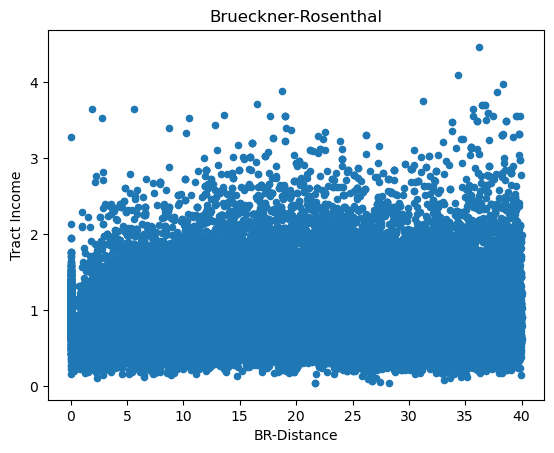

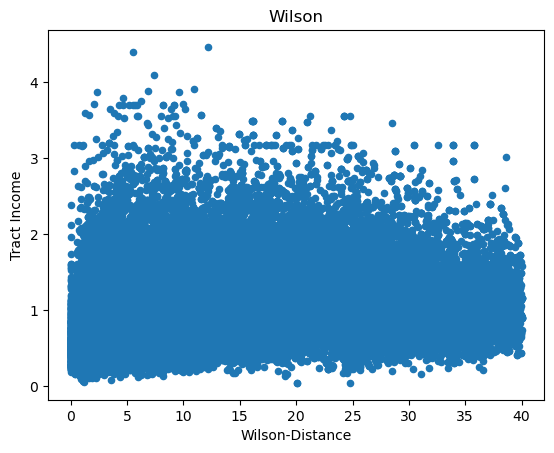

In [100]:
from matplotlib import pyplot as plt

br.plot(kind='scatter', x='distance', y='income', xlabel='BR-Distance', ylabel='Tract Income', title='Brueckner-Rosenthal')
wilson.plot(kind='scatter', x='distance', y='income', xlabel='Wilson-Distance', ylabel='Tract Income', title='Wilson')

Text(0.5, 1.0, 'Brueckner-Rosenthal')

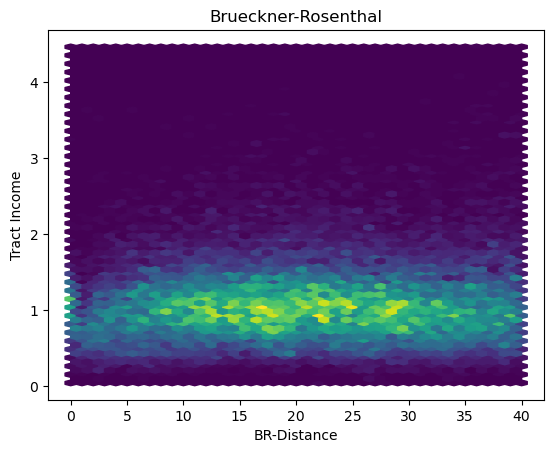

In [106]:
plt.hexbin(x=br['distance'], y=br['income'], gridsize=(40, 40))
plt.xlabel('BR-Distance')
plt.ylabel('Tract Income')
plt.title('Brueckner-Rosenthal')

Text(0.5, 1.0, 'Wilson')

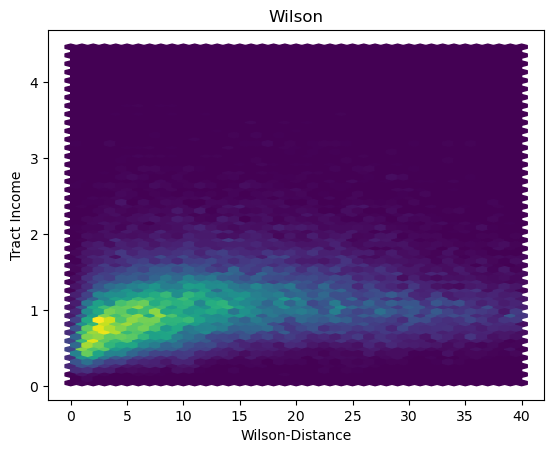

In [108]:
plt.hexbin(x=wilson['distance'], y=wilson['income'], gridsize=(40, 40))
plt.xlabel('Wilson-Distance')
plt.ylabel('Tract Income')
plt.title('Wilson')

In [126]:
def add_tract_counts(df: pd.DataFrame) -> pd.DataFrame:
    tract_counts =df.groupby('msa_code').count()['income']
    tract_counts = tract_counts.reset_index().rename({'income': 'tract_counts'}, axis=1)
    return pd.merge(right=df, left=tract_counts, left_on='msa_code', right_on='msa_code')

def discretize_distances(df: pd.DataFrame) -> pd.DataFrame:
    df['dist_bin'] = df['distance'].round()
    return df

def split_df_by_tract_counts(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    under_100 = df[df['tract_counts'] < 100]
    btw_100_500 = df[(df['tract_counts'] >= 100) & (df['tract_counts'] < 500)]
    btw_500_1000 = df[(df['tract_counts'] >= 500) & (df['tract_counts'] < 1000)]
    larger_1000 = df[df['tract_counts'] >= 1000]

    return (under_100, btw_100_500, btw_500_1000, larger_1000)

def plot_relative_income(df: pd.DataFrame, title: str, dist: str) -> None:
    df_dist_inc = df.groupby('dist_bin').mean()['income']
    plt.plot((df_dist_inc - df_dist_inc[0]) / df_dist_inc[0])
    plt.xlabel(f'{dist}-Distance from CBD (mi)')
    plt.ylabel('Median Income Compared to Mile Zero')
    plt.title(title)

def plot_housing_dist(df: pd.DataFrame) -> None:
    df.groupby('dist_bin').mean()[
    ['built_1999_2000', 
        'built_1995_1998', 
        'built_1990_1994', 
        'built_1980_1989', 
        'built_1970_1979', 
        'built_1960_1969', 
        'built_1950_1959', 
        'built_1940_1949', 
        'built_1939_earlier']
    ].plot(xlabel='Distance from CBD (mi)', ylabel='Mean Share of Housing Age')

def process_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return split_df_by_tract_counts(discretize_distances(add_tract_counts(df)))

In [125]:
under_100_br, btw_100_500_br, btw_500_1000_br, larger_1000_br = process_dataframe(br)
under_100_wilson, btw_100_500_wilson, btw_500_1000_wilson, larger_1000_wilson = process_dataframe(wilson)

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


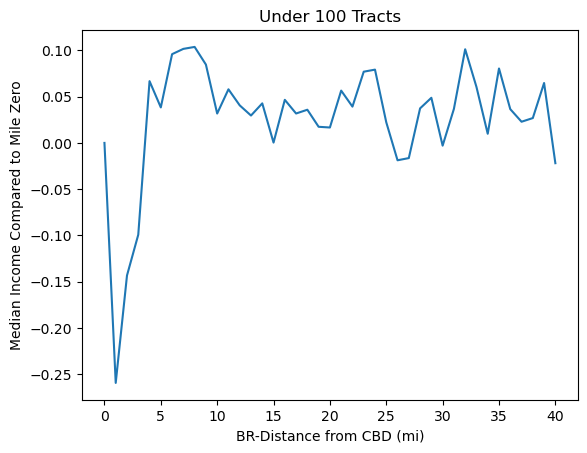

In [129]:
plot_relative_income(under_100_br, 'Under 100 Tracts', 'BR')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


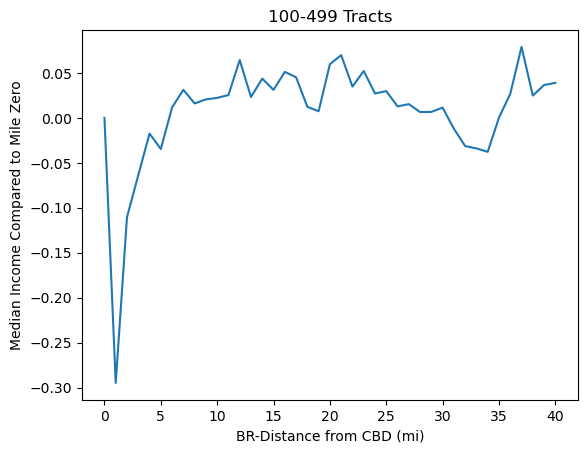

In [130]:
plot_relative_income(btw_100_500_br, '100-499 Tracts', 'BR')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


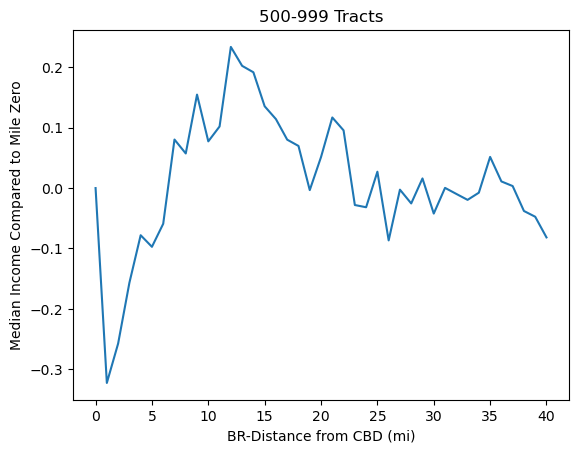

In [131]:
plot_relative_income(btw_500_1000_br, '500-999 Tracts', 'BR')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


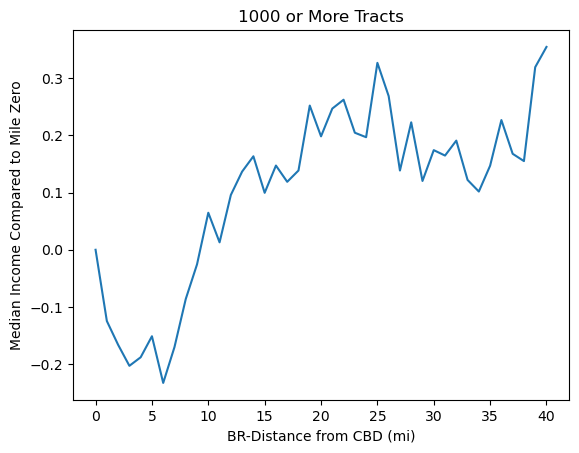

In [132]:
plot_relative_income(larger_1000_br, '1000 or More Tracts', 'BR')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


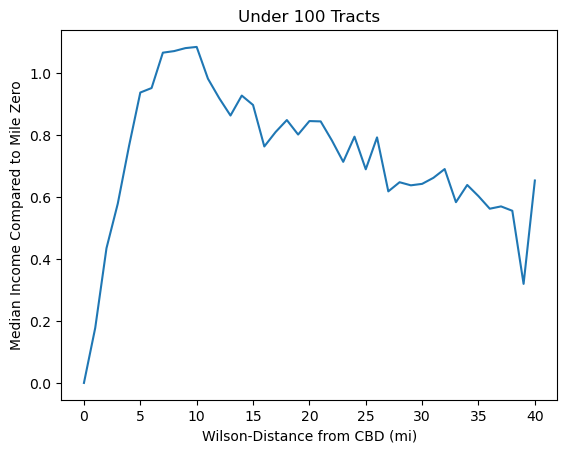

In [133]:
plot_relative_income(under_100_wilson, 'Under 100 Tracts', 'Wilson')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


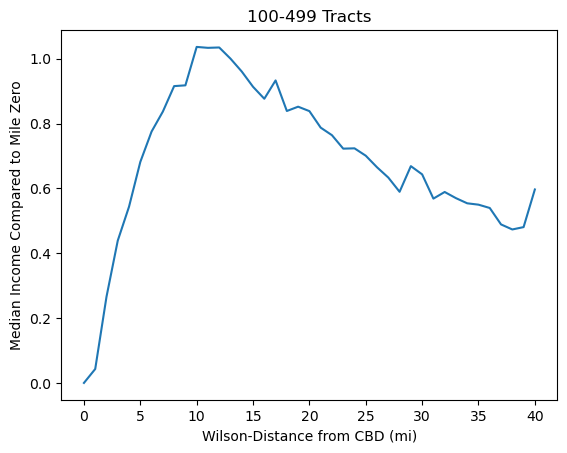

In [134]:
plot_relative_income(btw_100_500_wilson, '100-499 Tracts', 'Wilson')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


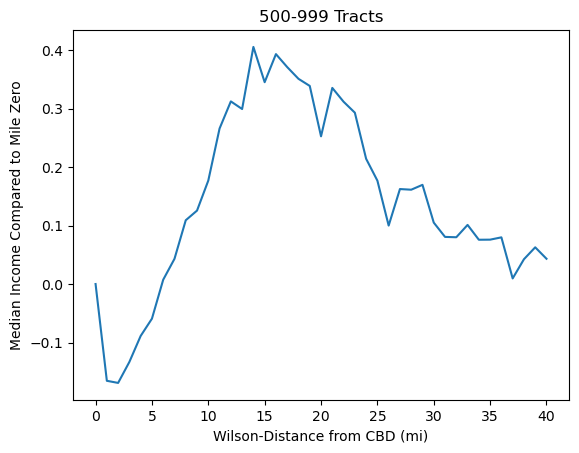

In [135]:
plot_relative_income(btw_500_1000_wilson, '500-999 Tracts', 'Wilson')

/tmp/ipykernel_6436/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


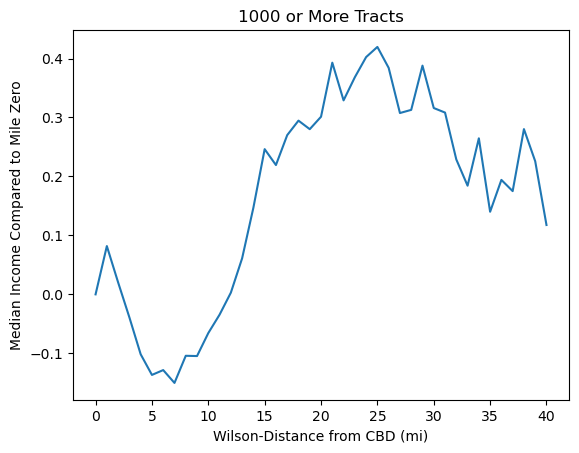

In [136]:
plot_relative_income(larger_1000_wilson, '1000 or More Tracts', 'Wilson')

## Mapping

In [ ]:
import geopandas

ca_geo = geopandas.read_file('./data/CA_shapefile/tl_2010_06_tract00.shp')
ca_geo

In [ ]:
ca_geo = ca_geo[['CTIDFP00', 'geometry']]

ca_geo['CTIDFP00'] = ca_geo['CTIDFP00'].astype(str).str.removeprefix('0')
data['tract_id_2010'] = data['tract_id_2010'].astype(str)

ca_geo = pd.merge(left=ca_geo, right=data, left_on='CTIDFP00', right_on='tract_id_2010')
ca_geo.dropna()